# Speech Emotion Recognition

---

# Abstract

The effect of emotional states on the voice is recognized by all people: For example, emotions such as love, fear, and anger can be recognized by sound.  With recent advances in speech recognition supported by neural networks, the time has come for computers to understand and use emotions as well. This project aims to show how emotional speech processing works in practice (though, in a simplified way). For this purpose, it will first be explained which speech features can be used to infer a person's emotional state and how these can be extracted. Using a public dataset, such features will be extracted and used to train an artificial neural network. As a result, the neural network is then able to recognize simple emotions for spontaneous audio recordings, which is eventually illustrated using a simple scenario.

In [1]:
import soundfile
import numpy as np
import librosa
import librosa.display
import glob
import os
import pickle
import sounddevice as sd
from IPython.display import display, Image, Audio, clear_output
from ipywidgets import Button, VBox, HBox, Output
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# The RAVDESS dataset

RAVDESS is an acronym and stands for **Ryerson Audio-Visual Database of Emotional Speech and Song**. This is a large data set consisting of an audio and video database of approximately 24GB in size. However, since this project only has a demonstrative function, only a small part of it will be used to train the model faster and keep things simple. The dataset was downloaded from [Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio) - a public web community that provides over 50,000 freely available datasets.

The portion of the dataset used here contains 1440 files: 60 recordings per actor x 24 actors, including 12 females and 12 males. Linguistic emotions include calm, happy, sad, angry, fearful, surprised, and disgusted expressions. The files are named according to a specific pattern which consists of seven parts in the following order:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


Below there are two recordings displayed that are included in the data set:

In [2]:
Audio("data/training_data/Actor_01/03-01-07-02-02-02-01.wav")

In [3]:
Audio("data/training_data/Actor_12/03-01-03-02-01-01-12.wav")

# Feature extraction

The pitch of a person's voice is a good indicator of their emotional state of mind. With sadness, for example, a person speaks with a lower pitch and rather monotonously, whereas with anger and joy the voice is higher and the speech melody more varied. Therefore, it makes sense to extract and utilize these features for emotion determination.

In machine learning and pattern recognition, a feature is a single measurable characteristic. Feature selection is a critical element of effective algorithms in pattern recognition, classification, and regression. Features are usually numeric, but structural features such as strings and graphs are used in syntactic pattern recognition. In speech recognition, phoneme recognition features may include noise ratios, length of sounds, relative power, filter matches, and many others.

As with any machine learning experiment, the first step is to collect data. The task is to extract features that can then be fed into an algorithm. Within this project, the following features are used:
- Mel spectograms
- Mel Frequency Cepstral Coefficients
- Chroma features

## The Mel Scale

In order to understand Mel spectrograms, we need to understand the Mel Scale first. Speech signals usually contain tones with different frequencies, where each tone has an actual frequency (Hz), and a subjective frequency. This means that the human ear perceives the tone frequency different based on the actual frequency of tones. It is more difficult for the ear to differentiate frequencies in high ranges than to differentiate frequencies that are in low ranges.

#### Example:
Consider the tones listed below with the frequencies 300Hz, 400Hz, 900Hz and 1000Hz: There is a 100Hz difference between the first two sounds as well as the last two sounds. However, the perceived distance between the first two sounds may seem greater than that between the last two, even though the actual difference is the same. 

#### 300 Hz tone

In [4]:
Audio("data/frequency_samples/300hz-tone.mp3")

#### 400 Hz tone

In [5]:
Audio("data/frequency_samples/400hz-tone.mp3")

#### 900 Hz tone

In [6]:
Audio("data/frequency_samples/900hz-tone.mp3")

#### 1000 Hz tone

In [7]:
Audio("data/frequency_samples/1khz-tone.mp3")

Basically, the Mel Scale (as seen below) is a logarithmic transformation of a signal's frequency which aims to represent this subjective perception of tone frequencies by the human ears.

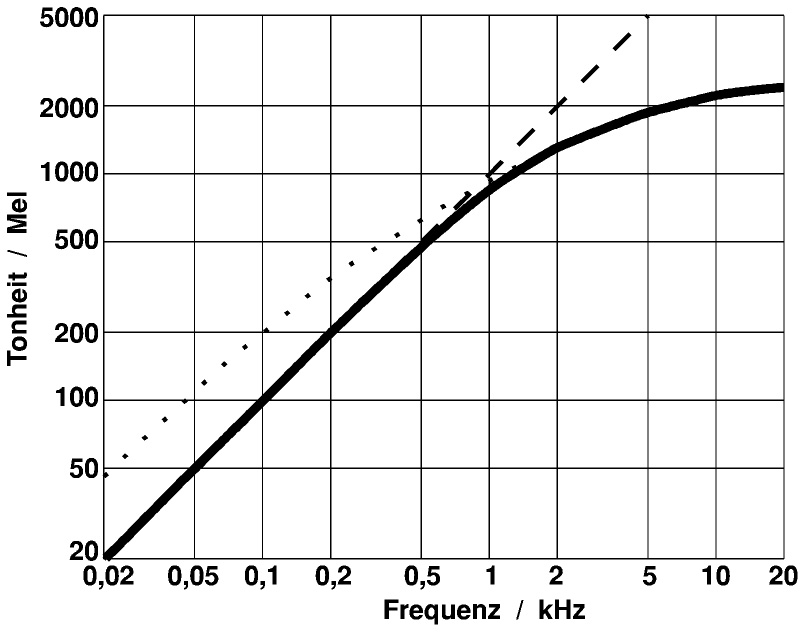

In [8]:
Image("data/images/mel-scale.jpg", width=500, height=500)

For **frequencies up to about 500 Hz**, the frequency scale and the Mel Scale are almost proportional. Thus, a doubling of frequency from 100 Hz to 200 Hz results in a doubling of tonality from 100 mel to 200 mel (as perceived in the example of tones). For **frequencies greater than 500 Hz**, frequency and tonality have a nonlinear relationship. For example, the frequency of a tone must be increased from 1500 Hz to 10,000 Hz to achieve a doubling of tonality from 1100 mel to 2200 mel. I.e., in this frequency range, tone intervals are perceived to be smaller than they actually are.

The frequency f (hertz) can be converted to m (mel) as follows:

$ m = 2595 log_{10} (1 + \frac{f}{700}) $

## Mel spectrograms

A spectrogram is a way to visually represent a signal's loudness, or amplitude, as it varies over time at different frequencies. Mel spectrograms are basically the same but visualize sounds on the Mel scale. This feature data can then be used to train an artificial neural network. The following Mel spectrogram represents the recording of the first actor shown above.

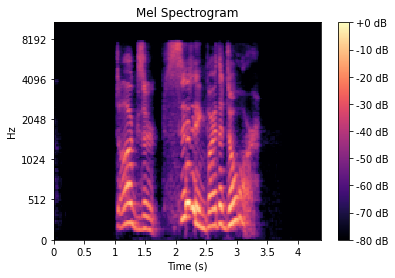

In [9]:
audio, sample_rate = librosa.load("data/training_data/Actor_01/03-01-07-02-02-02-01.wav")
mel_spect = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, x_axis='s', y_axis='mel')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

## Mel Frequency Cepstral Coefficients (MFCC)

Mel Frequency Cepstral Coefficients were originally used in various speech processing techniques, however, as the field of Music Information Retrieval began to develop further adjunct to Machine Learning, it was found that MFCCs could represent timbre quite well. It would be too much to go into further detail here, but for some basic understanding MFCCs in a sense can be thought of a "spectrum of a spectrum". Basically, you take the logarithm of the Mel representation of the audio, take the lagirthmic magnitude of it and use a Discrete Cosine Transformation on that. This creates a spectrum over Mel frequencies as opposed to time, thus creating MFCCs.


## Chroma Features

The chroma feature is a descriptor, which represents the tonal content of a musical audio signal in a condensed form. Therefore chroma features can be considered as important prerequisite for high-level semantic analysis, like chord recognition or harmonic similarity estimation. The underlying observation is that humans perceive two musical pitches as similar in color if they differ by an octave. Based on this observation, a pitch can be separated into two components, which are referred to as tone height and chroma. Assuming the [equal-tempered scale](https://en.wikipedia.org/wiki/Equal_temperament), one considers twelve chroma values represented by the set: {C, C♯, D, D♯, E , F, F♯, G, G♯, A, A♯, B}

The main idea of chroma features is to aggregate for a given time window all information that relates to a given chroma into a single coefficient. Shifting the time window across the music representation results in a sequence of chroma features each expressing how the representation's pitch content within the time window is spread over the twelve chroma bands.

The following image serves to illustrate the chroma features:  
(a) Musical score of a C-major scale.  
(b) Chromagram obtained from the score.  
(c) Audio recording of the C-major scale played on a piano.  
(d) Chromagram obtained from the audio recording.  

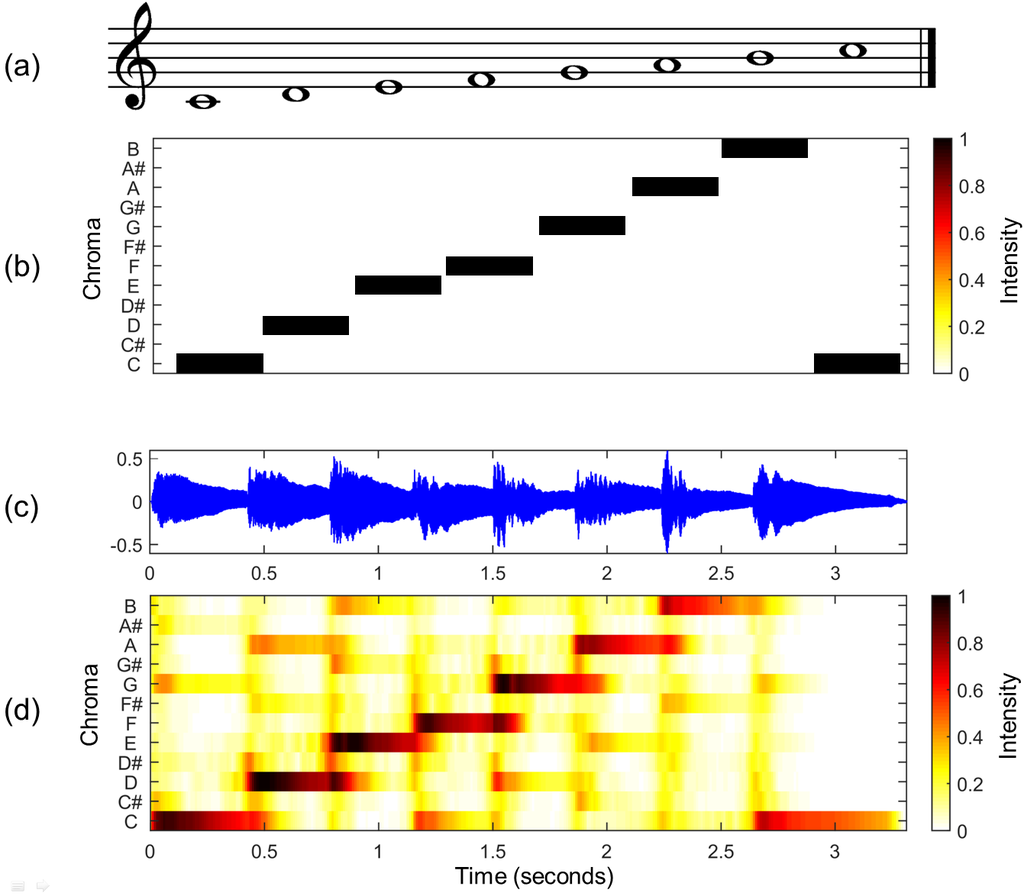

In [10]:
Image("data/images/chromagram.png", width=600, height=600)

---

# Labels

In order for a neural network to classify inputs, it needs knowledge about the classes of the inputs. Each data item in the training dataset is thus identified with a label, its class. During the training of the network, the class labels are used to evaluate the performance of the model. For this purpose, the class of the data element predicted by the model is compared with the actual class. This difference is called the error, which is to be minimized during training.  
After training, i.e. when the model is used, the classes are used to classify the inputs that the network has never processed before.

*emotion_labels* are all labels, which are contained in the data set.   
To improve the performance of the network in this prototypical setup, the set of labels is somewhat limited here. The labels available in this example are those from the dictionary *available_emotions*.

In [11]:
emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

available_emotions = {
    "angry",
    "sad",
    "disgust",
    "happy",
}

In order to classify audio signals by means of a neural network, it is necessary to preprocess the signal in advance in order to extract special features from the signal. The determined features are then used as inputs for the model.  

The desired features, which were explained above, are calculated with the help of the library *librosa* and returned as a Numpy array. This gives a collection of features for each element of the data set.

In [12]:
def extract_audio_feature(X, sample_rate):
    result = np.array([])

    # mfcc
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfccs))
        
    #chroma
    stft = np.abs(librosa.stft(X))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma))
        
    # mel
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    return result

In [13]:
def load_from_file(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        return extract_audio_feature(X, sample_rate)

The *load_training_data* function is used to load the data needed to train the network and return a train-test split of the data set. The train split, as the name suggests, is used purely for training the model. The test split, on the other hand, is used exclusively to evaluate the performance of the network. This can be used to measure how well the model has generalized the training data and provides correct predictions on unknown data.

In [14]:
def load_training_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("data/Training_Data/Actor_*/*.wav"):
        basename = os.path.basename(file)
        emotion = emotion_labels[basename.split("-")[2]]
        if emotion not in available_emotions:
            continue
        features = load_from_file(file)
        X.append(features)
        y.append(emotion)
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [15]:
# load RAVDESS dataset, 75% training 25% testing
X_train, X_test, y_train, y_test = load_training_data(test_size=0.25)

print("[+] Number of training samples:", X_train.shape[0])
print("[+] Number of testing samples:", X_test.shape[0])
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 576
[+] Number of testing samples: 192
[+] Number of features: 180


To conveniently create, evaluate, save and load the model, the functions *create_model*, *evaluate_model*, *save_model* and *load_model* have been implemented:

In [16]:
def create_model():
    # best model, determined by a grid search
    model_params = {
        "alpha": 0.01,
        "batch_size": 32,
        "epsilon": 1e-08,
        "hidden_layer_sizes": (300,),
        "learning_rate": "adaptive",
        "max_iter": 500
    }
   
    # init multi layer perceptron classifier with best parameters (so far)
    model = MLPClassifier(**model_params)
    
    print("[*] Training the model...")
    model.fit(X_train, y_train)
    return model

def evaluate_model(model):
    # predict 25% of data to measure how good we are
    y_pred = model.predict(X_test)

    # calculate the accuracy
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f"Accuracy: {accuracy*100}%")

def save_model(model, filename):
    file = open(filename, 'wb')
    pickle.dump(model, file)

def load_model(filename):
    file = open(filename,'rb')
    return pickle.load(file)

In [17]:
train_model = False
model = None

if train_model:
    print("Creating new model...")
    model = create_model()
    evaluate_model(model)
    save_model(model, "model")
else:
    print("Using saved model...")
    model = load_model("model")
    evaluate_model(model)

Using saved model...
Accuracy: 68.22916666666666%


# Demonstration of the emotional speech recognition

In the following, the emotional speech recognition will be demonstrated using the previously trained model. The demonstration consists of the following scenario: By pressing a start button, the scenario begins, whereby various images are shown at seven-second intervals. At the same time, a separate voice recording starts running in the background for each image, which is supposed to record the spoken reaction of the test person. It is therefore extremely important that the test subject says something to each image. What is said is completely unimportant, since the speech recognition is limited only to the transmitted emotion, which is subsequently determined for each image, and with the help of the trained model. Finally, the images shown are displayed with their corresponding emotions, which should stimulate a discussion about the correctness of the recognized emotion and the feeling of the test person during the execution.

### How can emotional speech recognition be used in speech control?
There are many application areas for which emotional speech processing or voice control would be conceivable. If we look at the behavior of a voice assistant such as Amazon's Alex or Apple's Siri, for example, it is quite conceivable that the speaker's behavior would adapt to the recognized emotion of the user. 

Example: The user asks the voice assistant a question, which is then processed by the voice assistant. The user receives an answer which does not answer his question satisfactorily - which is why he interrupts the voice assistant in an annoyed manner and terminates the answer to his question. The speaker classifies this emotion correctly and notes that his answer was insufficient, which causes him to change his approach to answering the next, similar question. If it is determined that the user gives a positive emotion subsequent to the answer, the Speaker recognizes that the manner of processing used was satisfactory and uses this approach again for similar situations.

---

The *record* function takes the audio signal, orders the feature extraction, and causes the model to make a prediction. This is returned to the caller. The recording time here is 7 seconds, which for this use case is the best compromise between "There is enough time to say something" and "It takes too long until a new image appears".

In [18]:
def record():
    duration = 7
    fs = 16000 #Samplerate
    recording = sd.rec(int(duration * fs),samplerate=fs, channels=1)
    sd.wait() # Recording
    features = extract_audio_feature(recording.reshape(-1), fs)
    return model.predict(features.reshape(1, -1))[0]

The test images used in this scenario are located inside the *data* folder. Their paths and categories (which are corresponding to the expected emotion) are now determined by the *get_images* function and stored in a list for later use and returned to the caller.

In [19]:
def get_images(path):
    """Returns all image paths and their corresponding emotion within the specified path"""
    images = []
    for root, directories, files in os.walk(traversal_path):
        for file in files:
            category = root.split("\\")[-1]  # folder name = emotion
            path = root + "/" + file
            image = {
                "path": path,
                "category": category
            }
            images.append(image)
    return images

The function *start_projection* takes care of the correct running of the scenario and is called at startup. In addition, it is responsible for the correct display of the images and starts a new audio recording for each new image, which is assigned to the respective image with the subsequently recognized emotion.

In [20]:
traversal_path = "data/images/categories"
images = get_images(traversal_path)

def start_projection(button):
    for image in images:
        image_path = image.get("path")
        with output:
            clear_output()
            display(Image(image_path, width=600, height=600))
        detected_emotion = record()
        image["detected_emotion"] = detected_emotion
    clear_output()

Here, a graphical user interface consisting of a start button is created, by pressing which the scenario can be started.

In [21]:
start_button = Button(
    description='',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Start projection',
    icon='play'
)
output = Output()
start_button.on_click(start_projection)

In [22]:
VBox([start_button, output])

In [ ]:
for image in images:
    plt.axis('off')
    plt.imshow(plt.imread(image["path"]))
    plt.title("Expected emotion: " + image["category"]+", Detected emotion: "+image["detected_emotion"])
    plt.show()

### Sources
Mel Scale and MFCC:  
https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8  
Chroma feature extraction:  
https://www.researchgate.net/publication/330796993_Chroma_Feature_Extraction  
https://www.aes.org/e-lib/browse.cfm?elib=15010  
RAVDESS dataset: https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio  
How to make a speech emotion recognizer: https://www.thepythoncode.com/article/building-a-speech-emotion-recognizer-using-sklearn  